In [1]:
!ls /content


sample_data


In [2]:
# Install libraries (run once)
!pip install tensorflow tensorflow-datasets nltk matplotlib seaborn scikit-learn

# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Load IMDB dataset from TFDS
ds = tfds.load('imdb_reviews', split=['train', 'test'], as_supervised=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.971L8T_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.971L8T_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.971L8T_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
# Convert training set to lists
texts = []
labels = []
for text, label in ds[0]:
    texts.append(text.numpy().decode('utf-8'))
    labels.append(label.numpy())

# Convert test set to lists
test_texts = []
test_labels = []
for text, label in ds[1]:
    test_texts.append(text.numpy().decode('utf-8'))
    test_labels.append(label.numpy())


In [5]:
# Check class balance
print("Mean of labels (should be ~0.5):", np.mean(labels))

# Word count stats
word_counts = [len(t.split()) for t in texts]
print("Average review length:", np.mean(word_counts))
print("Max review length:", np.max(word_counts))


Mean of labels (should be ~0.5): 0.5
Average review length: 233.7872
Max review length: 2470


In [6]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = ''.join(c for c in text if c.isalnum() or c.isspace())
    words = [w for w in text.split() if w not in stop_words]
    return ' '.join(words)

processed_texts = [preprocess(t) for t in texts]
processed_test_texts = [preprocess(t) for t in test_texts]


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(processed_texts)

sequences = tokenizer.texts_to_sequences(processed_texts)
test_sequences = tokenizer.texts_to_sequences(processed_test_texts)


In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded = pad_sequences(sequences, maxlen=200)
padded_test = pad_sequences(test_sequences, maxlen=200)


In [9]:
X_train, X_val, y_train, y_val = train_test_split(padded, labels, test_size=0.2, random_state=42)

X_test = padded_test
y_test = test_labels


In [10]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Check shapes
print("Shapes:", X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)


Shapes: (20000, 200) (20000,) (5000, 200) (5000,) (25000, 200) (25000,)


In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=10000, output_dim=128),  # input_length removed
    LSTM(128, dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 206s 324ms/step - accuracy: 0.7397 - loss: 0.5052 - val_accuracy: 0.8766 - val_loss: 0.3047
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 196s 313ms/step - accuracy: 0.9248 - loss: 0.2065 - val_accuracy: 0.8798 - val_loss: 0.3033
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 197s 316ms/step - accuracy: 0.9572 - loss: 0.1208 - val_accuracy: 0.8642 - val_loss: 0.3400
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 197s 316ms/step - accuracy: 0.9723 - loss: 0.0843 - val_accuracy: 0.8610 - val_loss: 0.4595


782/782 ━━━━━━━━━━━━━━━━━━━━ 75s 96ms/step - accuracy: 0.8674 - loss: 0.3257
Test Accuracy: 0.8694800138473511


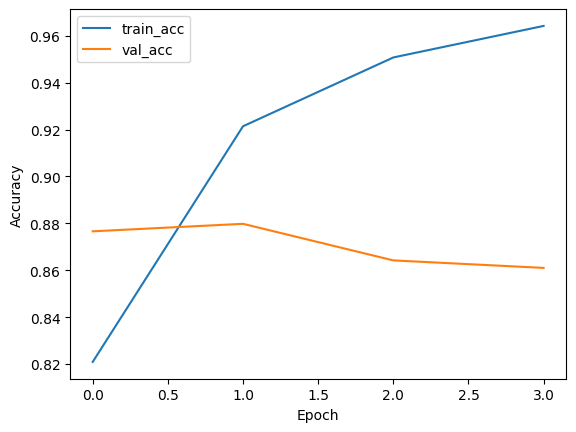

In [13]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

# Plot training history
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [14]:
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([preprocess(text)])
    pad = pad_sequences(seq, maxlen=200)
    pred = model.predict(pad)[0][0]
    return 'Positive' if pred > 0.5 else 'Negative'

# Example usage
predict_sentiment("This movie was amazing and exciting!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


'Positive'

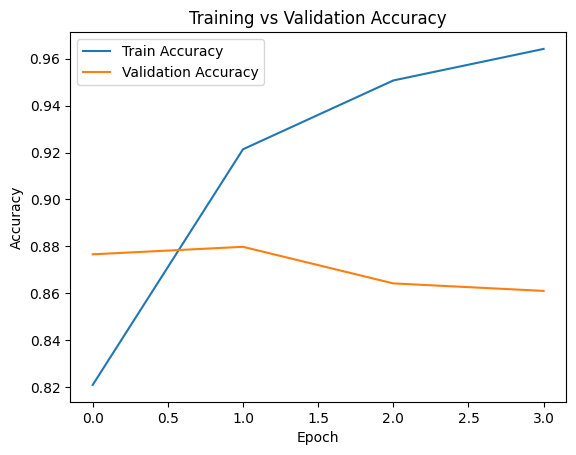

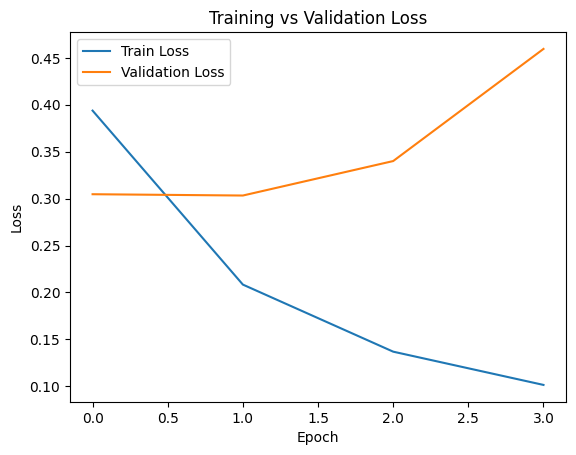

In [15]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [16]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = (model.predict(X_test) > 0.5).astype(int)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 92ms/step
[[11022  1478]
 [ 1785 10715]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     12500
           1       0.88      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



In [17]:
# Function already defined
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([preprocess(text)])
    pad = pad_sequences(seq, maxlen=200)
    pred = model.predict(pad)[0][0]
    return 'Positive' if pred > 0.5 else 'Negative'

# Demo input
while True:
    text = input("Enter a movie review (or 'quit' to stop): ")
    if text.lower() == 'quit':
        break
    print("Prediction:", predict_sentiment(text))


Enter a movie review (or 'quit' to stop): quit


In [18]:
# Save model
model.save("sentiment_model.keras")

# Save tokenizer
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("Files saved successfully")


Files saved successfully


In [19]:
!ls /content


sample_data  sentiment_model.keras  tokenizer.pkl


In [20]:
from google.colab import files
files.download('sentiment_model.keras')
files.download('tokenizer.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>